https://medium.com/@eyfydsyd97/bert-for-question-answer-fine-tuning%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%98%EC%97%AC-by-pytorch-fbe15fdef330

https://github.com/younggeun-kim/BERT_Question_Answering_PyTorch

https://github.com/kushalj001/pytorch-question-answering/blob/master/1.%20DrQA.ipynb

In [9]:
import torch
import numpy as np
import pandas as pd
import pickle
import re, os, string, typing, gc, json
import spacy
from collections import Counter
nlp = spacy.load('en')

In [10]:
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    print("Length of data: ", len(data['data']))
    print("Data Keys: ", data['data'][0].keys())
    print("Title: ", data['data'][0]['title'])
    
    return data

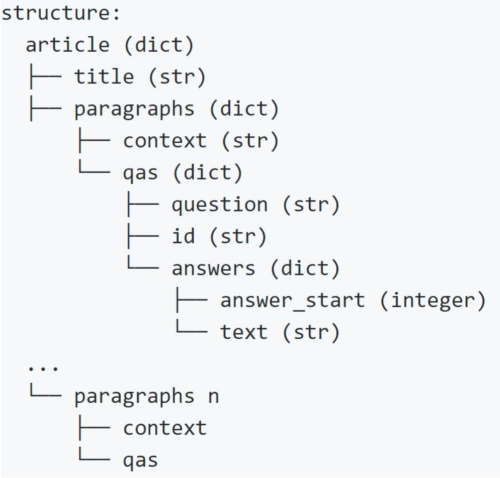

In [11]:
def parse_data(data:dict) -> list:
    """
    Squad 데이터 세트의 JSON 파일을
    key와 values을 입력하고 dictionry를 반환합니다.
    컨텍스트, query 및 레이블 트리플렛이 각 사전의 키가됩니다.
    """
    
    data = data['data']
    qa_list = []
    
    for paragraphs in data:
        for para in paragraphs['paragraphs']:
            cntext = para['context']
            
            for qa in para['qas']:
                id = eq['id']
                question = qe['question']
                
                for ans in qa['answers']:
                    answer = ans['text']
                    ans_start = ans['answer_start']
                    ans_end = ans_start + len(answer)
                    
                    qa_dict = {}
                    qa_dict['id'] = id
                    qa_dict['context'] = context
                    qa_dict['question'] = question
                    qa_dict['label'] = [ans_start, ans_end]
                    
                    eq_dict['answer'] = answer
                    qa_list.append(qa_dict)
                    
    return qa_list

In [12]:
def filter_large_examples(df):
    """
    임의의 값 이상의 컨텍스트 길이, 쿼리 길이 및 answer 길이가있는 예제의 ID를 반환합니다.
    그런 다음 이러한 ID를 데이터 프레임에서 삭제할 수 있습니다.
    이것은 QANet에서 명시 적으로 언급되지만 다른 모델에서도 가능합니다.
    """

    ctx_lens = []
    query_lens = []
    ans_lens = []
    for index, row in df.iterrows():
        cts_tokens = [w.text for w in nlp(row.cntext, disable=['parser', 'ner', 'tagger'])]
        if len(ctx_tokens) > 400:
            ctx_lens.append(row.name)
            
        query_tokens = [w.text for w in nlp(row.question, disable=['parser', 'tagger', 'ner'])]
        if len(query_tokens) > 50:
            query_lens.append(row.name)
            
        ans_tokens = [w.text for w in nlp(row.answer, disable=['parser', 'tagger', 'ner'])]
        if len(ans_tokens) > 30:
            ans_lens.append(row.name)
            
        assert row.name == index

    return set(ans_lens + ctx_lens + query_lens)

In [13]:
def gather_text_for_vocab(dfs:list):
    """
    문맥과 질문에서 텍스트를 수집하여 어휘를 만듭니다.
    
    : param dfs : SQUAD 데이터 세트의 데이터 프레임 목록.
    : returns : 컨텍스트 및 질문 목록
    """
    
    text = []
    total = 0
    for df in dfs:
        unique_contexts = list(df.context.unique())
        unique_questions = list(df.question.unique())
        total += df.context.nunique() + df.question.nunique()
        text.extend(unique_contexts + unique_questions)
        
    assert len(text) == total
    
    return text

In [ ]:
def build_word_vocab(vocab_text):
    """
    주어진 텍스트에서 word-level의 어휘를 만듭니다.
    
    : param list vocab_text : 컨텍스트 및 질문 목록
    : return
        dict word2idx : 단어를 인덱스로 매핑하는 단어
        dict idx2word : 정수 대 단어 매핑
        list word_vocab : 빈도별로 정렬 된 단어 목록
    """
    
    words = []
    for sent in vocab_text:
        for word in nlp(sent, disable=['parser', 'tagger', 'ner']):
            words.append(word.text)
            
    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    print(f"raw-vocab: {len(word_vocab)}")
    print(f"glove-vocab: {len(word_vocab)}")
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    print(f"vocab-length: {len(word_vocab)}")
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    print(f"word2idx-length: {len(word2idx)}")
    idx2word = {v:k for k,v in word2idx.items()}
    
    
    return word2idx, idx2word, word_vocab